# Import the necesasary packages and libraries

In [1]:
from collections import Counter
from itertools import combinations
from google.colab import drive

import json
import random
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Set the seed to 4332 for reproductibility

In [2]:
# Setting random seeds to replicate results easily
random.seed(4332)
np.random.seed(4332)
tf.random.set_seed(4332)

# Root Mean Squared Error (RMSE)

We need a reliable way to evaluate the performance of recommendation algorithms. RMSE is one of the popular metrics to estimate how good the recommendation algorithm is. Since RMSE is measuring the prediction errors, the smaller error that the model can achieve, the better performance it is, and vice versa.

$$RMSE=\sqrt{\sum_{i=1}^n\frac{(\hat{y}_i - y_i)^2}{N}}$$

$\hat{y}_i$: The predicted answer of sample $i$

$y$: The ground truth answer of sample $i$

In [3]:
def rmse(pred, actual):
    '''
    params:
        pred <np.array>: an array containing all predicted ratings
        actual <np.array>: an array containing all ground truth ratings

    return:
        a scalar whose value is the rmse
    '''
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

# Wide and Deep Learning (WDL) Model Implementation
The Wide and Deep Learning Model can be divided into two parts, the "wide" part and the "deep" part.

**The wide component** is a generalized linear model that takes in the raw input features and the cross-product transformation of categorical features, which enables it to **learn the co-occurrence patterns of items or features**.

**The deep component** is a Feed-forward Neural Network (FNN) which takes in both continuous and categorical features as input. Specifically, the normalized values of continuous features are concatenated with the low-dimensional dense embedding vectors converted from categorical features. This concatenated vector is then fed into the FNN during each foward pass. This mechanism tends to **increase the diversity of recommendations**.

In [4]:
def build_wdl_model(len_continuous, deep_vocab_lens, len_wide, embed_size):
    '''
    params:
        len_continuous: number of continuous features
        deep_vocab_lens: an array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
        len_wide: number of wide features
        embed_size: dimension of the embedding vectors of deep categorical features

    return:
        a keras Model object for the constructed wdl model
    '''
    # A list containing all input layers
    input_list = []

    # Input layer for continuous features
    continuous_input = Input(shape=(len_continuous,), dtype='float32', name='continuous_input')
    input_list.append(continuous_input)

    # Get embeddings for all deep categorical features
    emb_list = []
    for vocab_size in deep_vocab_lens:
        _input = Input(shape=(1,), dtype='int32')
        input_list.append(_input)
        _emb = Embedding(output_dim=embed_size, input_dim=vocab_size, input_length=1)(_input)
        _emb = Reshape((embed_size,))(_emb)
        emb_list.append(_emb)

    # Create input layer for deep component by concatenating the embeddings and continuous features' input layer
    deep_input = Concatenate()(emb_list + [continuous_input])

    # Construct deep component
    dense_1 = Dense(256, activation='relu')(deep_input)
    dense_1_dp = Dropout(0.3)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1_dp)
    dense_2_dp = Dropout(0.3)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2_dp)
    dense_3_dp = Dropout(0.3)(dense_3)

    # Create input layer for wide component
    wide_input = Input(shape=(len_wide,), dtype='float32')
    input_list.append(wide_input)

    # Concatenate the outputs of deep and wide components and feed the concatenated vector into the finall fully connected layer
    fc_input = Concatenate()([dense_3_dp, wide_input])
    model_output = Dense(1)(fc_input)

    model = Model(inputs=input_list, outputs=model_output)
    return model

# Data Preprocessing
Below are utility functions that helps us retrieve the numerical values of different features from the dataset, and generate combinations of features to be used by the WDL model.

### Retrieving Continuous Features

In [5]:
def get_continuous_features(df, continuous_columns):
    '''
    params:
        df: input dataframe
        continuous_columns: column names of continuous features

    return:
        a numpy array where each row contains the values of continuous features in the corresponding row of the input dataframe
    '''
    continuous_features = df[continuous_columns].values
    return continuous_features

### Categorical Features Cross Product Transformation
This function is used to generate a variety of feature combinations that occurred frequently in the dataset.

For example, the following items occurred frequently in the dataset:

|Item Name|Occurrence|
|---|---|
|A|4|
|B|3|
|C|2|
|D|1|

If we set `topk=3`, it means that we will only consider the top 3 items with the highest occurrence to generate combinations.

If we set `comb_p=2`, it means that we will generate combinations with 2 items in each generated combinations.

In this case, the following combinations will be generated: `[('A', 'B'), ('A', 'C'), ('B', 'C')]`

Test code: `get_top_k_p_combinations(pd.DataFrame({'item_categories': ['A, B, C, D', 'A, B, C', 'A, B', 'A']}), comb_p=2, topk=3, output_freq=False)`

In [6]:
def get_top_k_p_combinations(df, comb_p, topk, output_freq=False):
    '''
    params:
        df: input dataframe
        comb_p: number of elements in each combination (e.g., there are two elements in the combination {fried chicken, chicken and waffle}, and three elements in the combination {fried chicken, chicken and waffle, chicken fried rice})
        topk: number of most frequent combinations to retrieve
        output_freq: whether to return the frequencies of retrieved combinations

    return:
        1. output_freq = True: a list X where each element is a tuple containing a combination tuple and corresponding frequency, and the elements are stored in the descending order of their frequencies
        2. output_freq = False: a list X where each element is a tuple containing a combination tuple, and the elements are stored in the descending order of their frequencies
    '''
    def get_category_combinations(categories_str, comb_p=2):
        # categories = categories_str.split(', ')
        categories = categories_str
        return list(combinations(categories, comb_p))

    data = df["category"]
    all_categories_p_combos = data[df["category"].notnull()].apply(lambda x: get_category_combinations(x, comb_p)).values.tolist()
    all_categories_p_combos = [tuple(t) for item in all_categories_p_combos for t in item]
    tmp = dict(Counter(all_categories_p_combos))
    sorted_categories_combinations = list(sorted(tmp.items(), key=lambda x: x[1], reverse=True))
    if output_freq:
        return sorted_categories_combinations[:topk]
    else:
        return [t[0] for t in sorted_categories_combinations[:topk]]

### Building Wide Features

In [7]:
def get_wide_features(df, selected_categories_to_idx, top_combinations):
    '''
    params:
        df: input dataframe
        selected_categories_to_idx: a dictionary mapping item categories to corrresponding integral indices
        top_combinations: a list containing retrieved mostly frequent combinantions of item categories

    return:
        a numpy array where each row contains the categorical features' binary encodings and cross product transformations for the corresponding row of the input dataframe
    '''
    def categories_to_binary_output(categories):
        binary_output = [0 for _ in range(len(selected_categories_to_idx))]
        # for category in categories.split(', '):
        for category in categories:
            if category in selected_categories_to_idx:
                binary_output[selected_categories_to_idx[category]] = 1
            else:
                binary_output[0] = 1
        return binary_output
    def categories_cross_transformation(categories):
        # current_category_set = set(categories.split(', '))
        current_category_set = set(categories)
        corss_transform_output = [0 for _ in range(len(top_combinations))]
        for k, comb_k in enumerate(top_combinations):
            if len(current_category_set & comb_k) == len(comb_k):
                corss_transform_output[k] = 1
            else:
                corss_transform_output[k] = 0
        return corss_transform_output

    data = df["category"]

    category_binary_features = np.array(data[df["category"].notnull()].apply(lambda x: categories_to_binary_output(x)).values.tolist())
    category_cross_transform_features = np.array(data[df["category"].notnull()].apply(lambda x: categories_cross_transformation(x)).values.tolist())
    wide_features = np.concatenate((category_binary_features, category_cross_transform_features), axis=1)

    print("The shape of category_binary_features is: ", category_binary_features.shape)
    print("The shape of category_cross_transform_features is: ", category_cross_transform_features.shape)
    print("The shape of wide_featuresis: ", wide_features.shape)
    print("\n")

    return wide_features

# Ratings Prediction

### Loading train, validation and test rating tables

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# tr_df = pd.read_csv("data/review.csv")
# val_df = pd.read_csv("data/validation.csv")
# te_df = pd.read_csv("data/prediction.csv")

In [9]:
tr_df = pd.read_csv("/content/drive/MyDrive/COMP4332 Project 3/data/review.csv")
val_df = pd.read_csv("/content/drive/MyDrive/COMP4332 Project 3/data/validation.csv")
te_df = pd.read_csv("/content/drive/MyDrive/COMP4332 Project 3/data/prediction.csv")

In [10]:
tr_df.head(10)

,ReviewerID,ProductID,Text,Summary,Star
0,A1K4S4MWXI9E9M,B000FC27TA,Purchased more out of curiosity than any real ...,"Not my favorite, but...",3.0
1,A3LF914GG87TWP,B000FC27TA,"I actually received this text as an ebook, sin...",An interesting read,4.0
2,A1CNQTCRQ35IMM,B000FCKPG2,REVIEWER'S OPINION:\nThis was labeled as roman...,This was labeled romance but there was less ro...,2.0
3,ACVNKHUOX3QWU,B000GCFWXW,I liked this story although its probably not o...,Different,4.0
4,AU510CVD9XDG,B000GCFWXW,I have been saving the Argeneau novels for awh...,Science Fiction not Paranormal Romance,2.0
5,A2J8WQHKV75MAS,B000GCFWXW,HATED IT!!!! What was this ? Love by committee...,Hated it!! Too many cousins and endless inner ...,1.0
6,A80A5V4QGQQYR,B000GCFWXW,Greg a psychologist who specializes in phobias...,Mother kidnaps a husband,4.0
7,ARKMO0OABCW9I,B000GCFWXW,A typical yet different vampire story; I thoug...,Not that impressed,3.0
8,A3B53R6SZY97ZE,B000GCFWXW,Am I crazy? I loved the idea of an hansome psy...,This still is one of my favorite Argenueau books!,5.0
9,AY5R3F55U7WZ5,B000JMKRTI,I like all of Fern Michaels Sisterhood books. ...,great,5.0


In [11]:
val_df.head(10)

,ReviewerID,ProductID,Star
0,A3CMIEYL0TJLC2,B01DCM610A,5.0
1,AC97LVZ0C0TSK,B00TIUEVL2,5.0
2,A2X6LA6IS2C32K,B00DLSTT9Q,5.0
3,A5KRI5P7KR7SK,B018RFX3I0,4.0
4,A244C0ORREA3N5,B00UXLO4N0,5.0
5,A2WG33SBOT901X,B015XWK88S,5.0
6,A30M81Y20W9VTO,B0165I3VSS,4.0
7,A16EVINGPOU4U6,B005I5GYUC,4.0
8,A2SS0DL9SZ4CKW,B015VKB8KY,5.0
9,A18LI83Q1F5DKU,B00LAKB87S,3.0


In [12]:
te_df.head(10)

,ReviewerID,ProductID,Star
0,A369BMHORFPL0O,B018A8EDV0,0
1,A24ETSYVDJB5D3,B016VIVLJ8,0
2,A2HX0B5ELOPP5Z,B01GYPPMNE,0
3,A244C0ORREA3N5,B014BR4A3A,0
4,A2B9C3FMYW18UN,B0134EZGY8,0
5,A2EAKYR4AEJU69,B00NK0MK8C,0
6,A38TZJEVGI7OJN,B00OGN5GXS,0
7,A3CMQYU4YPSAFM,B015IC42AI,0
8,A1I96OYAUJ3HQE,B01D0HVU76,0
9,A37P6T3YZ8KY2F,B00VRQNK58,0


In [13]:
tr_ratings = tr_df["Star"].values
val_ratings = val_df["Star"].values

In [14]:
len(tr_ratings)

52697

In [15]:
len(val_ratings)

6596

# Data Visualization

### Visualize the distribution of different stars in training dataset (review.csv)

The distribution of different stars in training dataset:  {5.0: 28787, 4.0: 15399, 3.0: 5604, 2.0: 1749, 1.0: 1158}




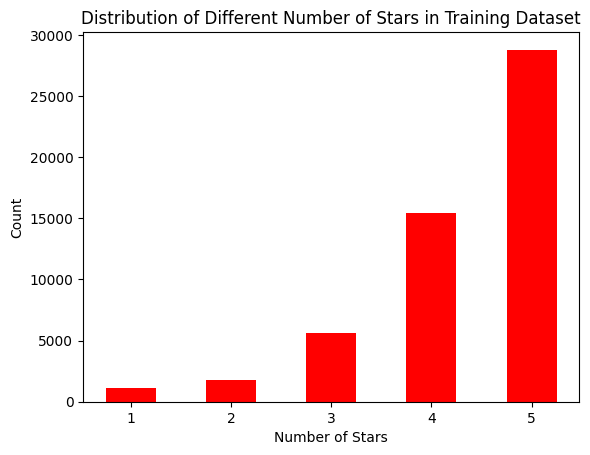

In [16]:
train_star_disrtibution = dict(tr_df["Star"].value_counts())

print("The distribution of different stars in training dataset: ", train_star_disrtibution)
print("\n")

train_star = list(train_star_disrtibution.keys())
train_star_count = list(train_star_disrtibution.values())

plt.title("Distribution of Different Number of Stars in Training Dataset")
plt.xlabel("Number of Stars")
plt.ylabel("Count")

plt.bar(train_star, train_star_count, color = "red", width = 0.5)

plt.show()

<Axes: >

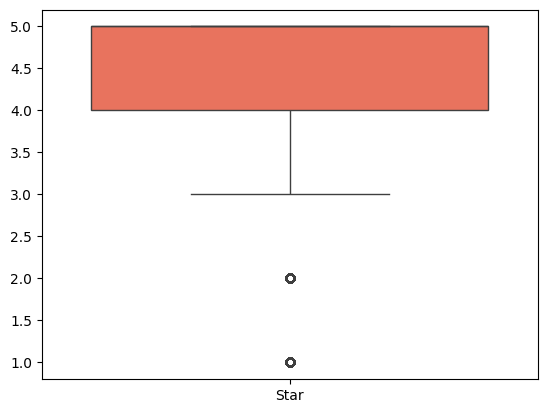

In [17]:
sns.boxplot(data = pd.DataFrame(tr_df["Star"]), color = "tomato")

### Visualize the distribution of different stars in validation dataset (validation.csv)

The distribution of different stars in validation dataset:  {5.0: 3155, 4.0: 2164, 3.0: 841, 2.0: 241, 1.0: 195}




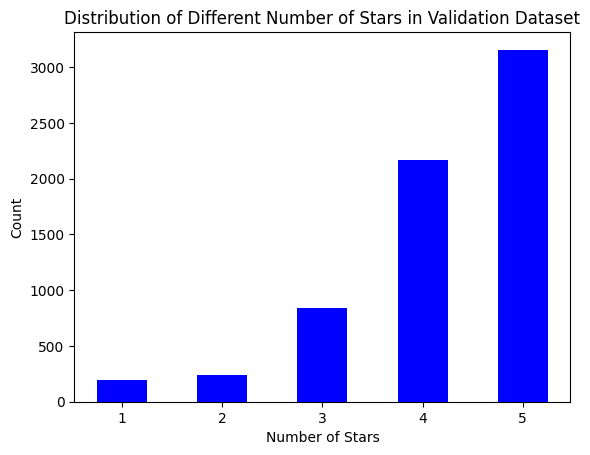

In [18]:
valid_star_disrtibution = dict(val_df["Star"].value_counts())

print("The distribution of different stars in validation dataset: ", valid_star_disrtibution)
print("\n")

valid_star = list(valid_star_disrtibution.keys())
valid_star_count = list(valid_star_disrtibution.values())

plt.title("Distribution of Different Number of Stars in Validation Dataset")
plt.xlabel("Number of Stars")
plt.ylabel("Count")

plt.bar(valid_star, valid_star_count, color = "blue", width = 0.5)

plt.show()

<Axes: >

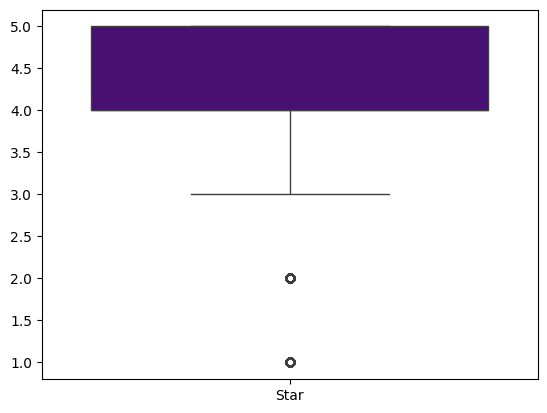

In [19]:
sns.boxplot(data = pd.DataFrame(val_df["Star"]), color = "indigo")

### Visualize the statistics of ProductID against Star in training dataset

In [20]:
train_ProductID_against_Star = tr_df[["ProductID", "Star"]].groupby(["ProductID"]).aggregate(["min", "max", "median", "mean", "std", "var", "count"]).sort_values(by = [("Star", "count")], ascending = False)

In [21]:
train_ProductID_against_Star

Star                                                
            min  max median      mean       std       var count
ProductID                                                      
B00YN6XHMU  1.0  5.0    5.0  4.058140  1.357807  1.843639    86
B00MZWA6KA  3.0  5.0    5.0  4.549296  0.580363  0.336821    71
B00R04OXC0  3.0  5.0    5.0  4.712121  0.519324  0.269697    66
B00JTCH5RQ  3.0  5.0    5.0  4.531250  0.590097  0.348214    64
B01CT5K792  2.0  5.0    5.0  4.442623  0.785803  0.617486    61
...         ...  ...    ...       ...       ...       ...   ...
B00GR0CK1Y  4.0  4.0    4.0  4.000000       NaN       NaN     1
B00GR0GQVY  5.0  5.0    5.0  5.000000       NaN       NaN     1
B00GSI39YW  4.0  4.0    4.0  4.000000       NaN       NaN     1
B00GSUA4ZC  4.0  4.0    4.0  4.000000       NaN       NaN     1
B00KVLYBXA  4.0  4.0    4.0  4.000000       NaN       NaN     1

[6341 rows x 7 columns]

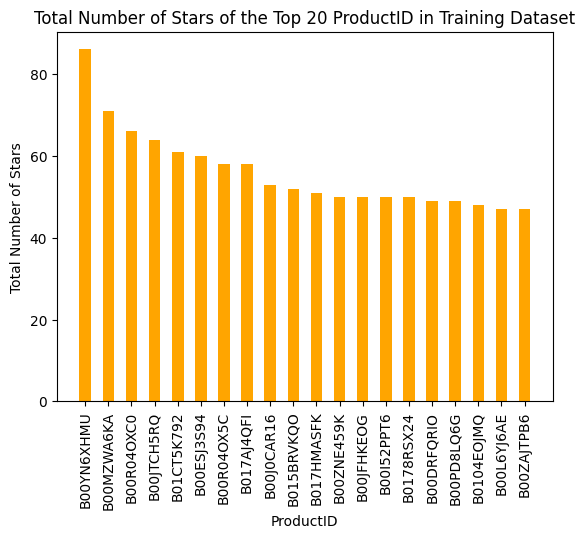

In [22]:
plt.bar(train_ProductID_against_Star.iloc[:20, :].index.values,
        train_ProductID_against_Star.iloc[:20, :][("Star", "count")],
        color = "orange",
        width = 0.5)

plt.title("Total Number of Stars of the Top 20 ProductID in Training Dataset")

plt.xlabel("ProductID")
plt.xticks(rotation = 90)

plt.ylabel("Total Number of Stars")

plt.show()

### Visualize the statistics of ProductID against Star in validation dataset

In [23]:
valid_ProductID_against_Star = val_df[["ProductID", "Star"]].groupby(["ProductID"]).aggregate(["min", "max", "median", "mean", "std", "var", "count"]).sort_values(by = [("Star", "count")], ascending = False)

In [24]:
valid_ProductID_against_Star

Star                                                
            min  max median      mean       std       var count
ProductID                                                      
B0165I3WGY  2.0  5.0    5.0  4.440000  0.711805  0.506667    25
B01BJST0FC  3.0  5.0    5.0  4.478261  0.730477  0.533597    23
B019B6WUGU  3.0  5.0    4.0  4.333333  0.658281  0.433333    21
B015BCX0OO  2.0  5.0    4.5  4.150000  1.039990  1.081579    20
B01FQ57CRC  2.0  5.0    5.0  4.722222  0.751904  0.565359    18
...         ...  ...    ...       ...       ...       ...   ...
B010YG21L0  5.0  5.0    5.0  5.000000       NaN       NaN     1
B010WM3TG2  4.0  4.0    4.0  4.000000       NaN       NaN     1
B00I6MYBSG  5.0  5.0    5.0  5.000000       NaN       NaN     1
B010W5GLWI  5.0  5.0    5.0  5.000000       NaN       NaN     1
B00GED9EQS  5.0  5.0    5.0  5.000000       NaN       NaN     1

[2773 rows x 7 columns]

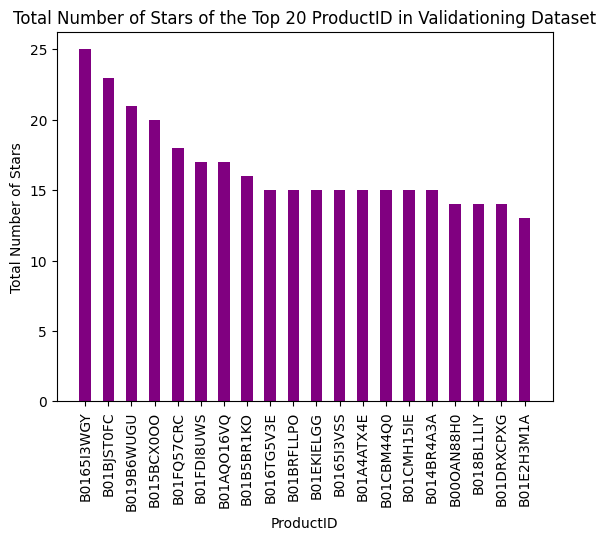

In [25]:
plt.bar(valid_ProductID_against_Star.iloc[:20, :].index.values,
        valid_ProductID_against_Star.iloc[:20, :][("Star", "count")],
        color = "purple",
        width = 0.5)

plt.title("Total Number of Stars of the Top 20 ProductID in Validationing Dataset")

plt.xlabel("ProductID")
plt.xticks(rotation = 90)

plt.ylabel("Total Number of Stars")

plt.show()

### Visualize the statistics of ReviewerID against Star in training dataset

In [26]:
train_ReviewerID_against_Star = tr_df[["ReviewerID", "Star"]].groupby(["ReviewerID"]).aggregate(["min", "max", "median", "mean", "std", "var", "count"]).sort_values(by = [("Star", "count")], ascending = False)

In [27]:
train_ReviewerID_against_Star

Star                                                
                min  max median      mean       std       var count
ReviewerID                                                         
A1JLU5H1CCENWX  4.0  5.0    5.0  4.955801  0.206107  0.042480   181
A3IQ0P3M39IY8U  1.0  5.0    4.0  3.814286  1.076804  1.159507   140
A2YJ8VP1SSHJ7   2.0  5.0    5.0  4.837209  0.556084  0.309230   129
A2VXSQHJWZAQGY  1.0  5.0    3.0  2.948718  0.839192  0.704244   117
A3KBRXW4PKK2MT  2.0  5.0    4.0  3.973214  0.752890  0.566844   112
...             ...  ...    ...       ...       ...       ...   ...
ASQIFMZ216FU9   5.0  5.0    5.0  5.000000       NaN       NaN     1
A7EACQIAIGBAR   5.0  5.0    5.0  5.000000       NaN       NaN     1
A9G85AO0S9UTB   5.0  5.0    5.0  5.000000       NaN       NaN     1
A3NIPJ7WT4LL60  5.0  5.0    5.0  5.000000       NaN       NaN     1
ACXRJX5J1NLM3   4.0  4.0    4.0  4.000000       NaN       NaN     1

[2755 rows x 7 columns]

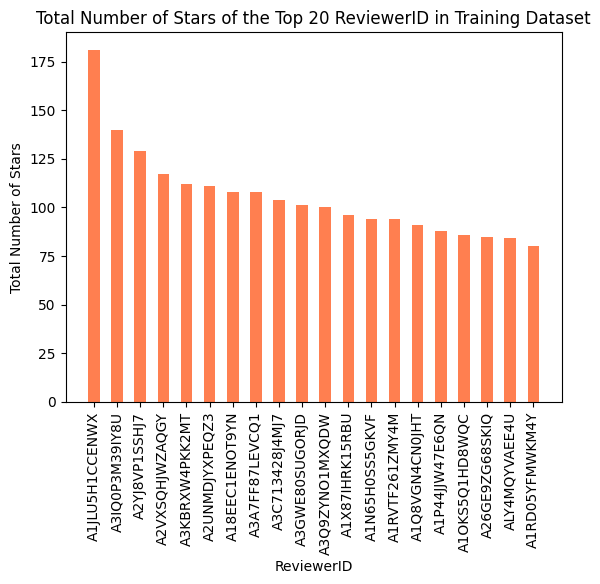

In [28]:
plt.bar(train_ReviewerID_against_Star.iloc[:20, :].index.values,
        train_ReviewerID_against_Star.iloc[:20, :][("Star", "count")],
        color = "coral",
        width = 0.5)

plt.title("Total Number of Stars of the Top 20 ReviewerID in Training Dataset")

plt.xlabel("ReviewerID")
plt.xticks(rotation = 90)

plt.ylabel("Total Number of Stars")

plt.show()

### Visualize the statistics of ReviewerID against Star in validation dataset

In [29]:
valid_ReviewerID_against_Star = val_df[["ReviewerID", "Star"]].groupby(["ReviewerID"]).aggregate(["min", "max", "median", "mean", "std", "var", "count"]).sort_values(by = [("Star", "count")], ascending = False)

In [30]:
valid_ReviewerID_against_Star

Star                                                
                min  max median      mean       std       var count
ReviewerID                                                         
A2S5EPJ451WL3I  2.0  5.0    4.0  3.528302  0.696247  0.484761    53
A18EEC1ENOT9YN  1.0  5.0    4.0  4.045455  0.861436  0.742072    44
A296HV17AZ10V9  1.0  5.0    4.0  3.931818  1.043200  1.088266    44
A7GZXYEZ2OMLQ   4.0  5.0    5.0  4.900000  0.303822  0.092308    40
A3A44JIMIWYFIE  2.0  5.0    4.0  3.861111  0.723198  0.523016    36
...             ...  ...    ...       ...       ...       ...   ...
A3QZAK4BXJBC2W  5.0  5.0    5.0  5.000000       NaN       NaN     1
A1AX02Z2IRSAY   4.0  4.0    4.0  4.000000       NaN       NaN     1
A2PCN97H7ORFXL  4.0  4.0    4.0  4.000000       NaN       NaN     1
A1J0R4BQMKXZMF  5.0  5.0    5.0  5.000000       NaN       NaN     1
A1RL1Q5LPSFZL6  4.0  4.0    4.0  4.000000       NaN       NaN     1

[1611 rows x 7 columns]

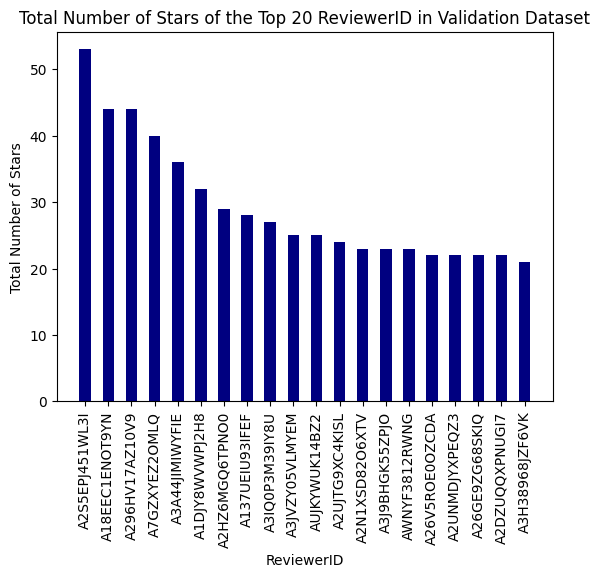

In [31]:
plt.bar(valid_ReviewerID_against_Star.iloc[:20, :].index.values,
        valid_ReviewerID_against_Star.iloc[:20, :][("Star", "count")],
        color = "navy",
        width = 0.5)

plt.title("Total Number of Stars of the Top 20 ReviewerID in Validation Dataset")

plt.xlabel("ReviewerID")
plt.xticks(rotation = 90)

plt.ylabel("Total Number of Stars")

plt.show()

# Loading content feautures of product.json

In [32]:
# user_df = pd.read_csv("data/user.csv", index_col=0)
# item_df = pd.read_csv("data/business.csv", index_col=0)

# # Renaming columns by adding prefixes to column names
# user_df = user_df.rename(index=str, columns={t: 'user_' + t for t in user_df.columns if t != 'user_id'})
# item_df = item_df.rename(index=str, columns={t: 'item_' + t for t in item_df.columns if t != 'business_id'})

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
product_df = pd.read_json("/content/drive/MyDrive/COMP4332 Project 3/data/product.json")
# product_df = pd.read_json("data/product.json")

In [35]:
product_df = product_df.join(pd.json_normalize(product_df["details"]))
product_df = product_df.drop(columns = ["details"])

In [36]:
product_df.head()

,category,tech1,description,fit,title,tech2,brand,feature,rank,main_cat,similar_item,date,price,imageURL,imageURLHighRes,ProductID,File Size:,Print Length:,Publisher:,Publication Date:,Language:,ASIN:,Word Wise:,Lending:,Page Numbers Source ISBN:,Simultaneous Device Usage:,Release Date:,ISBN-10:,ISBN-13:
0,"[Kindle Store, Kindle eBooks, Science Fiction ...",,[],,,,Visit Amazon's Elizabeth Moon Page,[],"88,963 Paid in Kindle Store (",Buy a Kindle,,NaT,,[],[],B000FBJBA4,2199 KB,314 pages,"Del Rey (September 30, 2003)","September 30, 2003",English,B000FBJBA4,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN
1,"[Kindle Store, Kindle eBooks, Politics & Socia...",,[],,,,Visit Amazon's Karl Marx Page,[],"1,358,073 Paid in Kindle Store (",Buy a Kindle,,NaT,,[],[],B000FC27TA,142 KB,160 pages,"Bantam Classics; Reissue edition (August 31, 2...","August 31, 2004",English,B000FC27TA,Enabled,Not Enabled,1438241569,NaN,NaN,NaN,NaN
2,"[Kindle Store, Kindle eBooks, Romance]",,[],,,,Visit Amazon's Allison Brennan Page,[],"94,006 Paid in Kindle Store (",Buy a Kindle,,NaT,,[],[],B000FCKPG2,739 KB,416 pages,"Ballantine Books (February 28, 2006)","February 28, 2006",English,B000FCKPG2,Enabled,Not Enabled,0345485238,NaN,NaN,NaN,NaN
3,"[Kindle Store, Kindle eBooks, Mystery, Thrille...",,[],,,,Visit Amazon's Lynsay Sands Page,[],"31,652 Paid in Kindle Store (",Buy a Kindle,,NaT,,[],[],B000GCFWXW,1011 KB,384 pages,"HarperCollins e-books (October 13, 2009)","October 13, 2009",English,B000GCFWXW,Enabled,Not Enabled,0373601387,NaN,NaN,NaN,NaN
4,"[Kindle Store, Kindle eBooks, Romance]",,[],,,,Visit Amazon's Fern Michaels Page,[],"1,031,468 Paid in Kindle Store (",Buy a Kindle,,NaT,,[],[],B000JMKRTI,519 KB,320 pages,"Zebra (June 1, 2006)","June 1, 2006",English,B000JMKRTI,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN


In [37]:
product_df["rank"] = product_df["rank"].str[:-23]
product_df["rank"] = product_df["rank"].str.replace(",", "", regex = False)
product_df["File Size:"] = product_df["File Size:"].str[:-3]
product_df["Print Length:"] = product_df["Print Length:"].str[:-6]

In [38]:
# product_df["rank"]

In [39]:
product_df.head()

,category,tech1,description,fit,title,tech2,brand,feature,rank,main_cat,similar_item,date,price,imageURL,imageURLHighRes,ProductID,File Size:,Print Length:,Publisher:,Publication Date:,Language:,ASIN:,Word Wise:,Lending:,Page Numbers Source ISBN:,Simultaneous Device Usage:,Release Date:,ISBN-10:,ISBN-13:
0,"[Kindle Store, Kindle eBooks, Science Fiction ...",,[],,,,Visit Amazon's Elizabeth Moon Page,[],88963,Buy a Kindle,,NaT,,[],[],B000FBJBA4,2199,314,"Del Rey (September 30, 2003)","September 30, 2003",English,B000FBJBA4,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN
1,"[Kindle Store, Kindle eBooks, Politics & Socia...",,[],,,,Visit Amazon's Karl Marx Page,[],1358073,Buy a Kindle,,NaT,,[],[],B000FC27TA,142,160,"Bantam Classics; Reissue edition (August 31, 2...","August 31, 2004",English,B000FC27TA,Enabled,Not Enabled,1438241569,NaN,NaN,NaN,NaN
2,"[Kindle Store, Kindle eBooks, Romance]",,[],,,,Visit Amazon's Allison Brennan Page,[],94006,Buy a Kindle,,NaT,,[],[],B000FCKPG2,739,416,"Ballantine Books (February 28, 2006)","February 28, 2006",English,B000FCKPG2,Enabled,Not Enabled,0345485238,NaN,NaN,NaN,NaN
3,"[Kindle Store, Kindle eBooks, Mystery, Thrille...",,[],,,,Visit Amazon's Lynsay Sands Page,[],31652,Buy a Kindle,,NaT,,[],[],B000GCFWXW,1011,384,"HarperCollins e-books (October 13, 2009)","October 13, 2009",English,B000GCFWXW,Enabled,Not Enabled,0373601387,NaN,NaN,NaN,NaN
4,"[Kindle Store, Kindle eBooks, Romance]",,[],,,,Visit Amazon's Fern Michaels Page,[],1031468,Buy a Kindle,,NaT,,[],[],B000JMKRTI,519,320,"Zebra (June 1, 2006)","June 1, 2006",English,B000JMKRTI,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN


# Expanding the table by using ProductID
Expanding the train, valiation and test dataset by using `ProductID` to query more features from `product_df`.

Rating & Review data (rating scale is 1.0-5.0) : <br>
review.csv : 52,697 ratings & reviews <br>
validation.csv : 6,596 (reviewer, product, rating) triples <br>
prediction.csv : 6,597 (reviewer, product) pairs <br>
(entries of ‘Star’ column in ‘prediction.csv’ are all set to 0.0) <br>

Product Information: <br>
product.json: 6,734 products <br>
(not guaranteed to include all products) <br>

In [40]:
tr_df_merged = pd.merge(pd.merge(tr_df, train_ReviewerID_against_Star["Star"], on = "ReviewerID", how = "left"), product_df, on = "ProductID", how = "left").reset_index(drop = True)
val_df_merged = pd.merge(pd.merge(val_df, train_ReviewerID_against_Star["Star"], on = "ReviewerID", how = "left"), product_df, on = "ProductID", how = "left").reset_index(drop = True)
te_df_merged = pd.merge(pd.merge(te_df, train_ReviewerID_against_Star["Star"], on = "ReviewerID", how = "left"), product_df, on = "ProductID", how = "left").reset_index(drop = True)

In [41]:
tr_df_merged

,ReviewerID,ProductID,Text,Summary,Star,min,max,median,mean,std,var,count,category,tech1,description,fit,title,tech2,brand,feature,rank,main_cat,similar_item,date,price,imageURL,imageURLHighRes,File Size:,Print Length:,Publisher:,Publication Date:,Language:,ASIN:,Word Wise:,Lending:,Page Numbers Source ISBN:,Simultaneous Device Usage:,Release Date:,ISBN-10:,ISBN-13:
0,A1K4S4MWXI9E9M,B000FC27TA,Purchased more out of curiosity than any real ...,"Not my favorite, but...",3.0,1.0,5.0,4.0,3.779661,1.035038,1.071303,59,"[Kindle Store, Kindle eBooks, Politics & Socia...",,[],,,,Visit Amazon's Karl Marx Page,[],1358073,Buy a Kindle,,NaT,,[],[],142,160,"Bantam Classics; Reissue edition (August 31, 2...","August 31, 2004",English,B000FC27TA,Enabled,Not Enabled,1438241569,NaN,NaN,NaN,NaN
1,A3LF914GG87TWP,B000FC27TA,"I actually received this text as an ebook, sin...",An interesting read,4.0,3.0,4.0,4.0,3.750000,0.500000,0.250000,4,"[Kindle Store, Kindle eBooks, Politics & Socia...",,[],,,,Visit Amazon's Karl Marx Page,[],1358073,Buy a Kindle,,NaT,,[],[],142,160,"Bantam Classics; Reissue edition (August 31, 2...","August 31, 2004",English,B000FC27TA,Enabled,Not Enabled,1438241569,NaN,NaN,NaN,NaN
2,A1CNQTCRQ35IMM,B000FCKPG2,REVIEWER'S OPINION:\nThis was labeled as roman...,This was labeled romance but there was less ro...,2.0,1.0,4.0,3.0,2.652174,1.027295,1.055336,23,"[Kindle Store, Kindle eBooks, Romance]",,[],,,,Visit Amazon's Allison Brennan Page,[],94006,Buy a Kindle,,NaT,,[],[],739,416,"Ballantine Books (February 28, 2006)","February 28, 2006",English,B000FCKPG2,Enabled,Not Enabled,0345485238,NaN,NaN,NaN,NaN
3,ACVNKHUOX3QWU,B000GCFWXW,I liked this story although its probably not o...,Different,4.0,2.0,5.0,4.0,3.757576,0.708445,0.501894,33,"[Kindle Store, Kindle eBooks, Mystery, Thrille...",,[],,,,Visit Amazon's Lynsay Sands Page,[],31652,Buy a Kindle,,NaT,,[],[],1011,384,"HarperCollins e-books (October 13, 2009)","October 13, 2009",English,B000GCFWXW,Enabled,Not Enabled,0373601387,NaN,NaN,NaN,NaN
4,AU510CVD9XDG,B000GCFWXW,I have been saving the Argeneau novels for awh...,Science Fiction not Paranormal Romance,2.0,1.0,4.0,3.0,2.944444,0.872604,0.761438,18,"[Kindle Store, Kindle eBooks, Mystery, Thrille...",,[],,,,Visit Amazon's Lynsay Sands Page,[],31652,Buy a Kindle,,NaT,,[],[],1011,384,"HarperCollins e-books (October 13, 2009)","October 13, 2009",English,B000GCFWXW,Enabled,Not Enabled,0373601387,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52692,A3JVZY05VLMYEM,B01FEY3ZY4,She came to do a job and she has learned more ...,Trained Bears,3.0,3.0,5.0,5.0,4.833333,0.429415,0.184397,48,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Bucking Bearback (BBW Shifter Cowboy Western R...,,Visit Amazon's Becca Fanning Page,[],793716,Buy a Kindle,,NaT,,[],[],3405,90,NaN,"May 9, 2016",English,B01FEY3ZY4,Enabled,Enabled,NaN,Unlimited,NaN,NaN,NaN
52693,A18LI83Q1F5DKU,B01FEY3ZY4,The ongoing trouble with Peterson and Snow is ...,LaGina,3.0,3.0,5.0,4.0,4.096774,0.538816,0.290323,31,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Bucking Bearback (BBW Shifter Cowboy Western R...,,Visit Amazon's Becca Fanning Page,[],793716,Buy a Kindle,,NaT,,[],[],3405,90,NaN,"May 9, 2016",English,B01FEY3ZY4,Enabled,Enabled,NaN,Unlimited,NaN,NaN,NaN
52694,A1SKQ5W90YXHF4,B01FPYJS1M,"Lee might be a violent, huge, dishonorably dis...",To Each His Own,4.0,2.0,5.0,5.0,4.514286,0.853072,0.727731,35,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Fighter Daddy eBook,,Visit Amazon's Marci Fawn Page,[],357833,Buy a Kindle,,NaT,,[],[],774,226,NaN,"May 14, 2016",English,B01FPYJS1M,Enabled,Enabled,NaN,Unlimited,NaN,NaN,NaN
52695,ABZ1AET0LHVQ1,B01FPYJS1M,A really good story. Lee and Raina are great c...,Awesome story!,4.0,4.0,5.0,5.0,4.941176,0.242536,0.058824,17,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Fighter

In [42]:
val_df_merged

,ReviewerID,ProductID,Star,min,max,median,mean,std,var,count,category,tech1,description,fit,title,tech2,brand,feature,rank,main_cat,similar_item,date,price,imageURL,imageURLHighRes,File Size:,Print Length:,Publisher:,Publication Date:,Language:,ASIN:,Word Wise:,Lending:,Page Numbers Source ISBN:,Simultaneous Device Usage:,Release Date:,ISBN-10:,ISBN-13:
0,A3CMIEYL0TJLC2,B01DCM610A,5.0,2.0,5.0,5.0,4.465753,0.765256,0.585616,73.0,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,BUY ME - The Complete Series - Kindle edition,,Visit Amazon's Alexa Riley Page,[],21501,Buy a Kindle,,NaT,,[],[],9448,403,NaN,"March 22, 2016",English,B01DCM610A,Enabled,Enabled,NaN,Unlimited,NaN,NaN,NaN
1,AC97LVZ0C0TSK,B00TIUEVL2,5.0,3.0,5.0,4.0,4.277778,0.669113,0.447712,18.0,"[Kindle Store, Kindle eBooks, Mystery, Thrille...",,[],,Desert Blood (The Wolves of Twin Moon Ranch Bo...,,Visit Amazon's Anna Lowe Page,[],193171,Buy a Kindle,,NaT,,[],[],1704,144,"Twin Moon Press (April 2, 2015)","April 2, 2015",English,B00TIUEVL2,Enabled,Enabled,NaN,NaN,NaN,NaN,NaN
2,A2X6LA6IS2C32K,B00DLSTT9Q,5.0,5.0,5.0,5.0,5.000000,0.000000,0.000000,15.0,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Sin at Sea (Sinful Series Book 1) - Kindle edi...,,Visit Amazon's Emma Nichols Page,[],703132,Buy a Kindle,,NaT,,[],[],480,153,NaN,"June 24, 2013",English,B00DLSTT9Q,Enabled,Enabled,NaN,NaN,NaN,NaN,NaN
3,A5KRI5P7KR7SK,B018RFX3I0,4.0,2.0,5.0,4.0,3.823529,1.131111,1.279412,17.0,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,In Love with Ezra (Love Unaccounted Book 2) - ...,,Visit Amazon's Love Belvin Page,[],43660,Buy a Kindle,,NaT,,[],[],3588,328,"MKT Publishing (November 29, 2015)","November 29, 2015",English,B018RFX3I0,Enabled,Enabled,NaN,NaN,NaN,NaN,NaN
4,A244C0ORREA3N5,B00UXLO4N0,5.0,2.0,5.0,4.0,4.360656,0.731045,0.534426,61.0,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Just Friends (Johnson Family Book 3) - Kindle ...,,Visit Amazon's Delaney Diamond Page,[],343142,Buy a Kindle,,NaT,,[],[],3075,209,"Garden Avenue Press (March 18, 2015)","March 18, 2015",English,B00UXLO4N0,Enabled,Enabled,NaN,Unlimited,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6591,AKZH6MEXHWGLD,B00JTIOYOM,5.0,1.0,5.0,5.0,4.000000,1.732051,3.000000,5.0,"[Kindle Store, Kindle eBooks, Romance]",,[],,Dare to Resist (Wedding Dare series Book 5) - ...,,Visit Amazon's Laura Kaye Page,[],275124,Buy a Kindle,,NaT,,[],[],1073,134,"Entangled: Brazen (May 12, 2014)","May 12, 2014",English,B00JTIOYOM,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN
6592,A3RNQ7PNKEU1UI,B0099LPCWC,4.0,4.0,5.0,4.0,4.200000,0.421637,0.177778,10.0,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Pride and Precipitation (Chick Flick Clique Ro...,,Visit Amazon's Heather Horrocks Page,[],2580,Buy a Kindle,,NaT,,[],[],2253,174,"Word Garden Press (January 14, 2014)","January 14, 2014",English,B0099LPCWC,Enabled,Enabled,NaN,Unlimited,NaN,NaN,NaN
6593,A556L66JGOVPK,B00DEJZZK4,5.0,4.0,5.0,5.0,4.764706,0.437237,0.191176,17.0,"[Kindle Store, Kindle eBooks, Science Fiction ...",,[],,Eden Rising (Eden Rising Post-Apocalyptic Ser...,,Visit Amazon's Andrew Cunningham Page,[],366442,Buy a Kindle,,NaT,,[],[],934,292,"Arcnovels (June 14, 2013)","June 14, 2013",English,B00DEJZZK4,Enabled,Enabled,NaN,NaN,NaN,NaN,NaN
6594,A253ZKSZTAZ8W7,B00CMJDOIC,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Kindle Store, Kindle eBooks, Romance]",,[],,Conduct Unbecoming of a Gentleman - Kindle edi...,,Visit Amazon's Wareeze Woodson Page,[],338853,Buy a Kindle,,NaT,,[],[],1528,304,"Soul Mate Publishing (January 17, 2014)","January 17, 2014",English,B00CMJDOIC,Enabled,Enabled,NaN,NaN,NaN,NaN,NaN


In [43]:
te_df_merged

,ReviewerID,ProductID,Star,min,max,median,mean,std,var,count,category,tech1,description,fit,title,tech2,brand,feature,rank,main_cat,similar_item,date,price,imageURL,imageURLHighRes,File Size:,Print Length:,Publisher:,Publication Date:,Language:,ASIN:,Word Wise:,Lending:,Page Numbers Source ISBN:,Simultaneous Device Usage:,Release Date:,ISBN-10:,ISBN-13:
0,A369BMHORFPL0O,B018A8EDV0,0,3.0,5.0,4.0,4.250000,0.753778,0.568182,12.0,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,"Barbecue, Bourbon and Bullets: A HoneyBun Shop...",,Visit Amazon's M.E. Harmon Page,[],1446,Buy a Kindle,,NaT,,[],[],284,54,NaN,"November 20, 2015",English,B018A8EDV0,Enabled,Not Enabled,NaN,Unlimited,NaN,NaN,NaN
1,A24ETSYVDJB5D3,B016VIVLJ8,0,3.0,5.0,5.0,4.517241,0.574499,0.330049,29.0,"[Kindle Store, Kindle eBooks, Romance]",,[],,"The Fractured Heart: A smoldering, sexy tattoo...",,Visit Amazon's Scarlett Cole Page,[],162979,Buy a Kindle,,NaT,,[],[],1052,442,"Swerve (January 5, 2016)","January 5, 2016",English,B016VIVLJ8,Enabled,Not Enabled,1250154847,NaN,NaN,NaN,NaN
2,A2HX0B5ELOPP5Z,B01GYPPMNE,0,3.0,5.0,4.0,4.000000,0.577350,0.333333,13.0,"[Kindle Store, Kindle eBooks, Romance]",,[],,Stud: A Novel - Kindle edition,,Visit Amazon's Jamie K. Schmidt Page,[],310720,Buy a Kindle,,NaT,,[],[],1885,205,"Loveswept (July 25, 2017)","July 25, 2017",English,B01GYPPMNE,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN
3,A244C0ORREA3N5,B014BR4A3A,0,2.0,5.0,4.0,4.360656,0.731045,0.534426,61.0,"[Kindle Store, Kindle eBooks, Romance]",,[],,Someone Like You: An Oxford Novel - Kindle edi...,,Visit Amazon's Lauren Layne Page,[],42555,Buy a Kindle,,NaT,,[],[],1284,252,"Loveswept (December 6, 2016)","December 6, 2016",English,B014BR4A3A,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN
4,A2B9C3FMYW18UN,B0134EZGY8,0,1.0,5.0,3.0,3.234375,0.955223,0.912450,64.0,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Hot SEALs: Protecting Julie (Book 6.5) (Kindle...,,Visit Amazon's Susan Stoker Page,[],236045,Buy a Kindle,,NaT,,[],[],261,93,"Kindle Worlds (July 30, 2015)","July 30, 2015",English,B0134EZGY8,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6592,A1YQ4CZ5XEC11P,B00VOYNKM6,0,4.0,5.0,4.0,4.375000,0.500000,0.250000,16.0,"[Kindle Store, Kindle eBooks, Romance]",,[],,Flawed: An Ethan Frost Novel - Kindle edition,,Visit Amazon's Tracy Wolff Page,[],240705,Buy a Kindle,,NaT,,[],[],1162,243,"Loveswept (January 17, 2017)","January 17, 2017",English,B00VOYNKM6,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN
6593,A16TE56LP5NUL5,B00GUZ195O,0,3.0,5.0,5.0,4.545455,0.564076,0.318182,33.0,"[Kindle Store, Kindle eBooks, Literature & Fic...",,[],,Mistletoe Magic (Bar V5 Ranch Book 2) - Kindle...,,Visit Amazon's Melissa McClone Page,[],136209,Buy a Kindle,,NaT,,[],[],976,40,"Tule Publishing Group (November 21, 2013)","November 21, 2013",English,B00GUZ195O,Enabled,Not Enabled,NaN,NaN,NaN,NaN,NaN
6594,A386CNLWZUF3EH,B00BFJY4IE,0,1.0,5.0,4.0,3.730769,1.372813,1.884615,26.0,"[Kindle Store, Kindle eBooks, Mystery, Thrille...",,[],,The Harbinger 1st Cycle Collection: Hard-boile...,,Visit Amazon's Carolyn McCray Page,[],254085,Buy a Kindle,,NaT,,[],[],12520,1256,NaN,"November 9, 2013",English,B00BFJY4IE,Enabled,Enabled,NaN,Unlimited,NaN,NaN,NaN
6595,A39CVMK2ZKEIK2,B0100BOE7S,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Kindle Store, Kindle eBooks, Romance]",,[],,Forbidden Temptation (Forbidden #3) - Kindle e...,,Visit Amazon's R.L. Kenderson Page,[],209507,Buy a Kindle,,NaT,,[],[],1018,254,"R.L. Kenderson (August 18, 2015)","August 18, 2015",English,B0100BOE7S,Enabled,Enabled,NaN,Unlimited,NaN,NaN,NaN


# Preparing continuous features

In [44]:
# Specify the columns containing conitnuous features
continuous_columns = ["mean", "median", "count", "rank", "File Size:", "Print Length:"]
#continuous_columns = ["mean", "median", "count", "rank", "File Size:", "Print Length:"]
# Get values of continous features for train/validation/test sets using the utility function defined previously

tr_continuous_features = get_continuous_features(tr_df_merged, continuous_columns)
val_continuous_features = get_continuous_features(val_df_merged, continuous_columns)
te_continuous_features = get_continuous_features(te_df_merged, continuous_columns)

# convert the continuous features to float data type

# tr_continuous_features[:,1] = tr_continuous_features[:,1].replace(",", "").astype(float)
# val_continuous_features[:,1] = val_continuous_features[:,1].replace(",", "").astype(float)
# te_continuous_features[:,1] = te_continuous_features[:,1].replace(",", "").astype(float)

tr_continuous_features = tr_continuous_features.astype(float)
val_continuous_features = val_continuous_features.astype(float)
te_continuous_features = te_continuous_features.astype(float)

# Standardize each feature by removing the mean of the training samples and scaling to unit variance.
# See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for more details.
scaler = StandardScaler().fit(tr_continuous_features)

tr_continuous_features = scaler.transform(tr_continuous_features)
val_continuous_features = scaler.transform(val_continuous_features)
te_continuous_features = scaler.transform(te_continuous_features)

tr_continuous_features[np.isnan(tr_continuous_features)] = 0
val_continuous_features[np.isnan(val_continuous_features)] = 0
te_continuous_features[np.isnan(te_continuous_features)] = 0

# Preparing deep categorical features

In [45]:
# Sepcify column names of deep categorical features

product_deep_columns = ["brand", "main_cat", "Publisher:", "Publication Date:", "Language:", "ASIN:", "Word Wise:", "Lending:", "Page Numbers Source ISBN:"]
# An array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
# Transforming words into indices for each categorical columns
product_deep_vocab_lens = []

for col_name in product_deep_columns:
    # Getting unique values of this deep categorical feature
    unique_values = product_df[col_name].unique()

    # Creating a dictionary to map from unique values to the corresponding index
    vocab = dict(zip(unique_values, range(1, len(unique_values)+1)))

    # Getting the number of unique values of this deep categorical features
    product_deep_vocab_lens.append(len(vocab)+1)

    # Creating a new column where each entry stores the index of this deep categorical feature's value in the same row
    product_df[col_name + "_idx"] = product_df[col_name].apply(lambda x: vocab[x])

# Creating a dictionary mapping each business id to corresponding values of deep categorical features
product_deep_idx_columns = [t + "_idx" for t in product_deep_columns]
#product_to_deep_categorical_features = dict(zip(product_df["ProductID"].values, product_df[product_deep_idx_columns].values.tolist()))

In [46]:
from collections import defaultdict

def def_value_for_deep_cat_feat_dict():
    return [0, 0, 0, 0, 0, 0, 0, 0, 0]

product_to_deep_categorical_features = defaultdict(def_value_for_deep_cat_feat_dict)

In [47]:
for key, value in zip(product_df["ProductID"].values, product_df[product_deep_idx_columns].values.tolist()):
    product_to_deep_categorical_features[key] = value

In [ ]:
# print(product_to_deep_categorical_features["B007GQYZZ2"])

[601, 1, 31, 461, 1, 698, 1, 2, 1]


In [ ]:
# print(product_to_deep_categorical_features["B005ZISF8Q"])

[0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# product_to_deep_categorical_features

defaultdict(<function __main__.def_value_for_deep_cat_feat_dict()>,
            {'B000FBJBA4': [1, 1, 1, 1, 1, 1, 1, 1, 1],
             'B000FC27TA': [2, 1, 2, 2, 1, 2, 1, 1, 2],
             'B000FCKPG2': [3, 1, 3, 3, 1, 3, 1, 1, 3],
             'B000GCFWXW': [4, 1, 4, 4, 1, 4, 1, 1, 4],
             'B000JMKRTI': [5, 1, 5, 5, 1, 5, 1, 1, 1],
             'B000QCS8YM': [6, 1, 6, 6, 1, 6, 1, 1, 1],
             'B000UZJRGI': [7, 1, 7, 7, 1, 7, 2, 1, 5],
             'B000V507D4': [8, 1, 8, 4, 1, 8, 1, 1, 1],
             'B000W4RFBQ': [9, 1, 9, 8, 1, 9, 1, 1, 1],
             'B000W916C0': [10, 1, 10, 4, 1, 10, 1, 1, 6],
             'B000W93A42': [11, 1, 11, 9, 1, 11, 1, 1, 1],
             'B000W966HU': [12, 1, 4, 4, 1, 12, 1, 1, 1],
             'B000WHVRZS': [13, 1, 12, 10, 1, 13, 1, 1, 1],
             'B000WJVJOK': [14, 1, 13, 11, 1, 14, 1, 1, 1],
             'B000WSFBO0': [15, 1, 14, 12, 1, 15, 1, 1, 1],
             'B000XPRRXK': [16, 1, 15, 13, 1, 16, 1, 1, 1],
            

In [48]:
# Creating numpy arrays storing corresponding deep categorical features' values of train/validation/test sets using the above mapping
tr_deep_categorical_features = np.array(tr_df_merged["ProductID"].apply(lambda x: product_to_deep_categorical_features[x]).values.tolist())
val_deep_categorical_features = np.array(val_df_merged["ProductID"].apply(lambda x: product_to_deep_categorical_features[x]).values.tolist())
te_deep_categorical_features = np.array(te_df_merged["ProductID"].apply(lambda x: product_to_deep_categorical_features[x]).values.tolist())

# Preparing wide features

##### Preparing binary encoding for each selected category

In [49]:
# Collect the categories of all items
# all_categories = [category for category_list in product_df.category.values for category in category_list.split(", ")]

all_categories = []

for cat_list in product_df.category.values:
    all_categories += cat_list

# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)

# Select top 500 most frequent categories
selected_categories = [t[0] for t in category_sorted[:500]]

# Create a dictionary mapping each secleted category to a unique integral index
selected_categories_to_idx = dict(zip(selected_categories, range(1, len(selected_categories) + 1)))

# Map all categories unseen in the item df to index 0
selected_categories_to_idx['unk'] = 0

# Create a dictionary mapping each integral index to corresponding category
idx_to_selected_categories = {val: key for key, val in selected_categories_to_idx.items()}

##### Preparing cross product transformation for categories

In [50]:
tr_df_merged["category"].isna().sum()

170

In [51]:
val_df_merged["category"].isna().sum()

17

In [52]:
te_df_merged["category"].isna().sum()

10

In [55]:
print(tr_df_merged["category"].mode()[0])

['Kindle Store', 'Kindle eBooks', 'Literature & Fiction']


In [56]:
print(val_df_merged["category"].mode()[0])

['Kindle Store', 'Kindle eBooks', 'Literature & Fiction']


In [57]:
print(te_df_merged["category"].mode()[0])

['Kindle Store', 'Kindle eBooks', 'Literature & Fiction']


In [58]:
tr_df_merged["category"] = tr_df_merged["category"].apply(lambda d: d if isinstance(d, list) else tr_df_merged["category"].mode()[0])

In [59]:
val_df_merged["category"] = val_df_merged["category"].apply(lambda d: d if isinstance(d, list) else val_df_merged["category"].mode()[0])

In [60]:
te_df_merged["category"] = te_df_merged["category"].apply(lambda d: d if isinstance(d, list) else te_df_merged["category"].mode()[0])

In [61]:
tr_df_merged["category"].isna().sum()

0

In [62]:
val_df_merged["category"].isna().sum()

0

In [63]:
te_df_merged["category"].isna().sum()

0

In [64]:
# Get most frequent categories combinantions using the utility function defined previously and store them in the folloing list
top_combinations = []

# Get top 50 most frequent two-categories combinantions in the train set

top_combinations += get_top_k_p_combinations(tr_df_merged, 2, 50, output_freq=False)

# Get top 30 most frequent three-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df_merged, 3, 30, output_freq=False)

# Get top 20 most frequent four-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df_merged, 4, 20, output_freq=False)

# Convert each combinantion in the list to a set data structure
top_combinations = [set(t) for t in top_combinations]

In [65]:
# Getting values of wide features for train/validation/test sets using the utility function defined previously
# The following matrices should have a shape of (n_samples, len(selected_categories_to_idx)+len(top_combinations))
tr_wide_features = get_wide_features(tr_df_merged, selected_categories_to_idx, top_combinations)
val_wide_features = get_wide_features(val_df_merged, selected_categories_to_idx, top_combinations)
te_wide_features = get_wide_features(te_df_merged, selected_categories_to_idx, top_combinations)

The shape of category_binary_features is:  (52697, 53)
The shape of category_cross_transform_features is:  (52697, 100)
The shape of wide_featuresis:  (52697, 153)


The shape of category_binary_features is:  (6596, 53)
The shape of category_cross_transform_features is:  (6596, 100)
The shape of wide_featuresis:  (6596, 153)


The shape of category_binary_features is:  (6597, 53)
The shape of category_cross_transform_features is:  (6597, 100)
The shape of wide_featuresis:  (6597, 153)




### Concatenating continuous features, deep categorical features and wide features as an input list

In [66]:
tr_features = []
tr_features.append(tr_continuous_features)
tr_features += [tr_deep_categorical_features[:, i] for i in range(tr_deep_categorical_features.shape[1])]
tr_features.append(tr_wide_features)

val_features = []
val_features.append(val_continuous_features)
val_features += [val_deep_categorical_features[:, i] for i in range(val_deep_categorical_features.shape[1])]
val_features.append(val_wide_features)

te_features = []
te_features.append(te_continuous_features)
te_features += [te_deep_categorical_features[:, i] for i in range(te_deep_categorical_features.shape[1])]
te_features.append(te_wide_features)

### Building the WDL

In [67]:
wdl_model = build_wdl_model(len(tr_continuous_features[0]), product_deep_vocab_lens,  len(tr_wide_features[0]), embed_size=100)

In [68]:
# tr_ratings = tr_df_merged["Star"].values
# val_ratings = val_df_merged["Star"].values

### Train the model using Adam optimizer and mean squared error loss

In [ ]:
#wdl_model.compile(optimizer='adam', loss='mse')

"""history = wdl_model.fit(
        tr_features,
        tr_ratings,
        batch_size = 128,
        epochs = 10,
        verbose = 1,
        validation_data=(val_features, val_ratings),
        shuffle=True,
        callbacks=[ModelCheckpoint("/content/drive/MyDrive/COMP4332 Project 3/model_removed_low_corr.h5",
                                   monitor="val_loss",
                                   mode="min",
                                   save_best_only = True)])"""

In [69]:
wdl_model.compile(optimizer='adagrad', loss='mse', metrics="accuracy")

history = wdl_model.fit(
        tr_features,
        tr_ratings,
        batch_size = 128,
        epochs = 20,
        verbose = 1,
        validation_data=(val_features, val_ratings),
        shuffle=True,
        callbacks=[ModelCheckpoint("/content/drive/MyDrive/COMP4332 Project 3/model.h5",
                                   monitor="val_loss",
                                   mode="min",
                                   save_best_only = True)])

Epoch 1/20
410/412 [============================>.] - ETA: 0s - loss: 5.3480 - accuracy: 0.0196

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


412/412 [==============================] - 10s 20ms/step - loss: 5.3306 - accuracy: 0.0196 - val_loss: 0.9600 - val_accuracy: 0.0296
Epoch 2/20
412/412 [==============================] - 4s 11ms/step - loss: 1.2862 - accuracy: 0.0220 - val_loss: 0.8629 - val_accuracy: 0.0296
Epoch 3/20
412/412 [==============================] - 5s 11ms/step - loss: 1.2124 - accuracy: 0.0220 - val_loss: 0.8165 - val_accuracy: 0.0296
Epoch 4/20
412/412 [==============================] - 6s 15ms/step - loss: 1.1447 - accuracy: 0.0220 - val_loss: 0.7905 - val_accuracy: 0.0296
Epoch 5/20
412/412 [==============================] - 4s 11ms/step - loss: 1.0991 - accuracy: 0.0220 - val_loss: 0.7734 - val_accuracy: 0.0296
Epoch 6/20
412/412 [==============================] - 5s 12ms/step - loss: 1.0636 - accuracy: 0.0220 - val_loss: 0.7648 - val_accuracy: 0.0296
Epoch 7/20
412/412 [==============================] - 6s 14ms/step - loss: 1.0450 - accuracy: 0.0220 - val_loss: 0.7533 - val_accuracy: 0.0296
Epoch 8/2

In [70]:
model = tf.keras.models.load_model("/content/drive/MyDrive/COMP4332 Project 3/model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

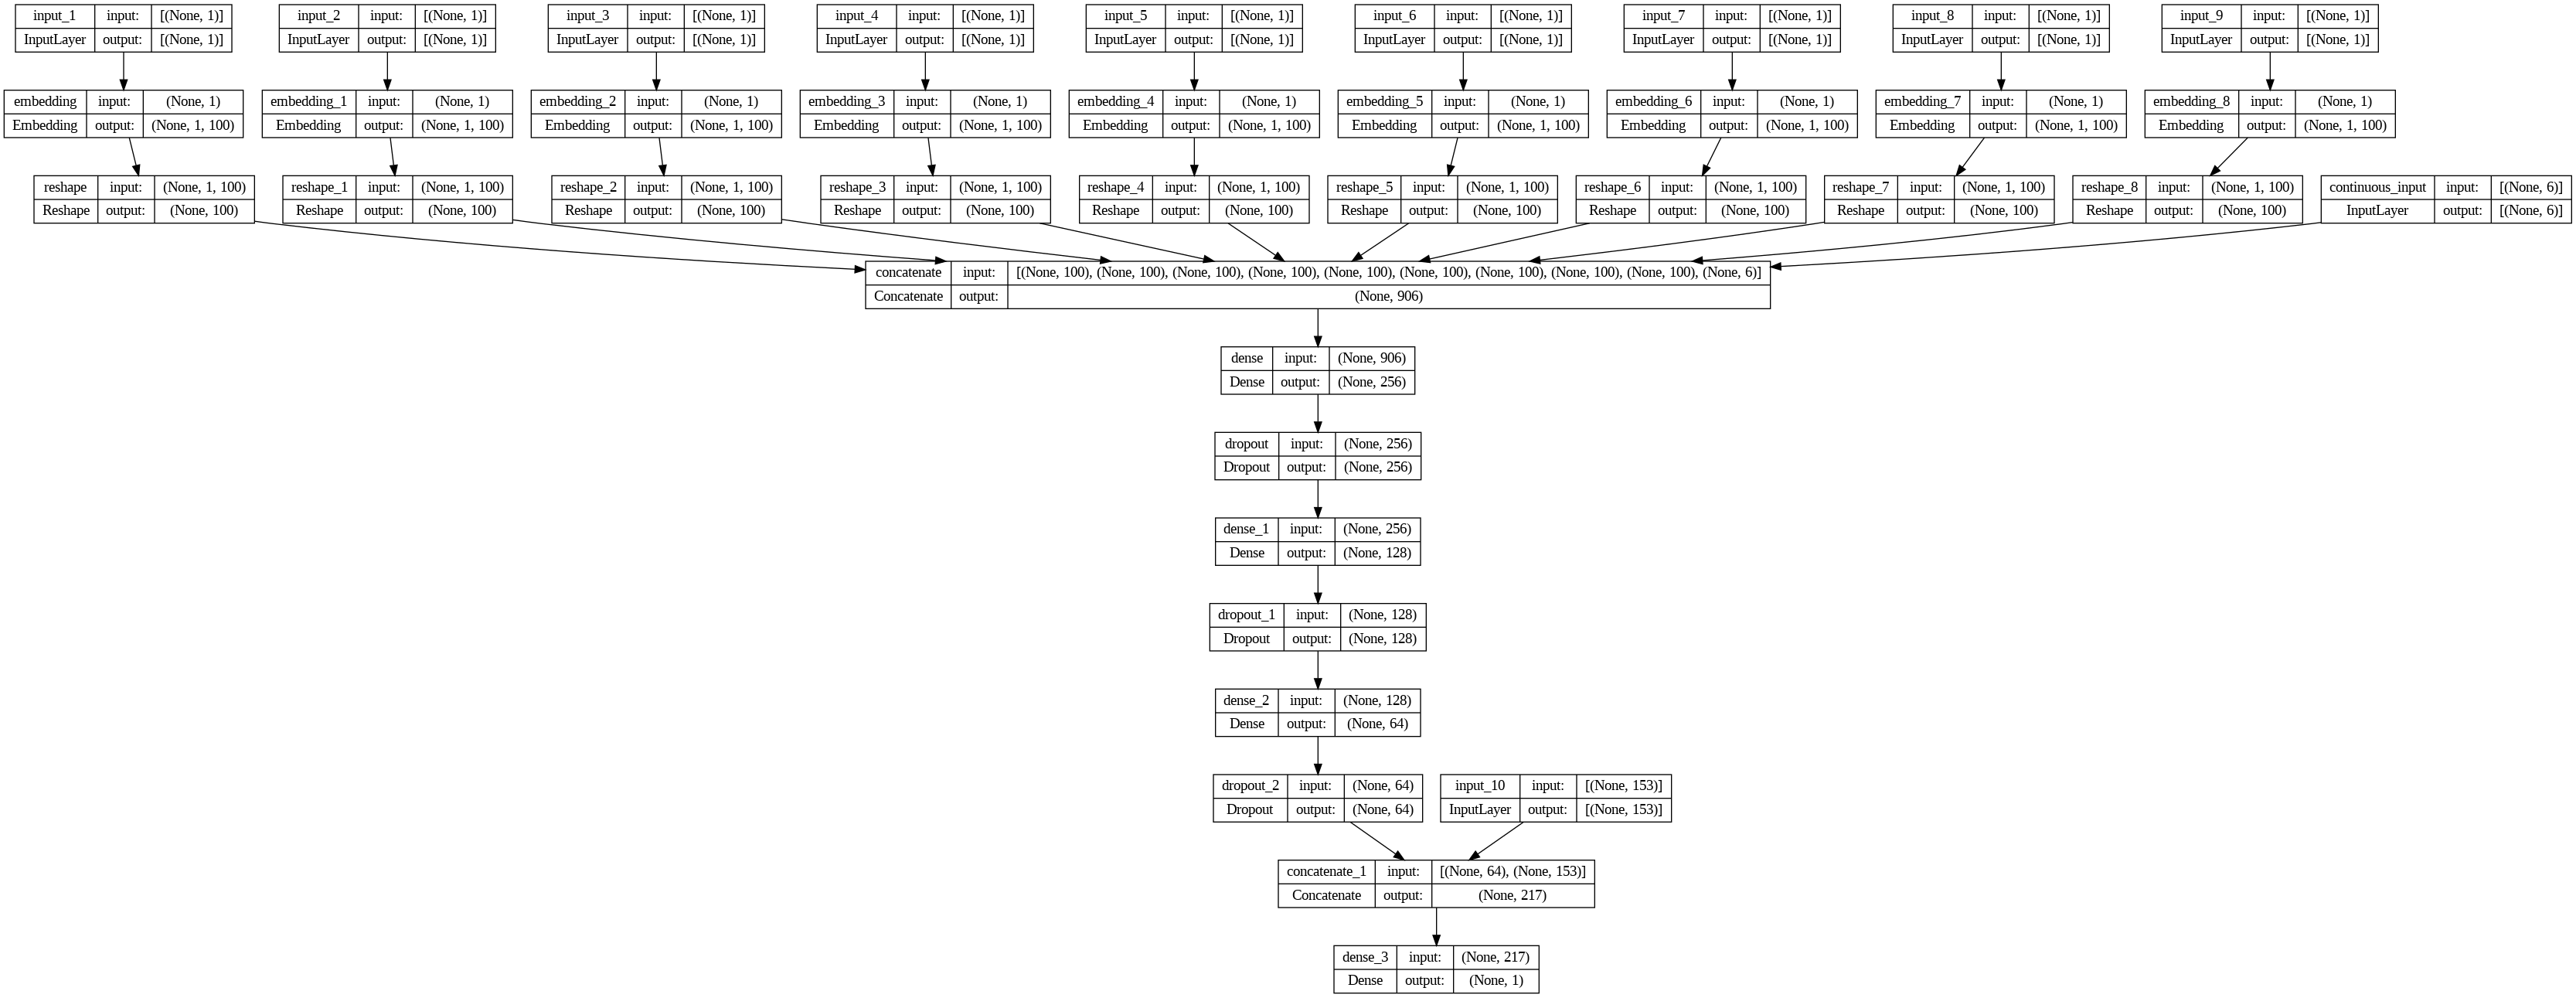

In [71]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

### Evaluate the model on train and validation sets using RMSE¶

In [72]:
y_tr_pred = model.predict(tr_features)
print("TRAIN RMSE: ", rmse(y_tr_pred, tr_ratings))
y_val_pred = model.predict(val_features)
print("VALID RMSE: ", rmse(y_val_pred, val_ratings))

1647/1647 [==============================] - 4s 2ms/step
TRAIN RMSE:  0.7185272470534991
207/207 [==============================] - 1s 4ms/step
VALID RMSE:  0.8476169795694477


In [73]:
len(y_val_pred)

6596

In [74]:
len(val_ratings)

6596

# Ploting the training history and the model loss history

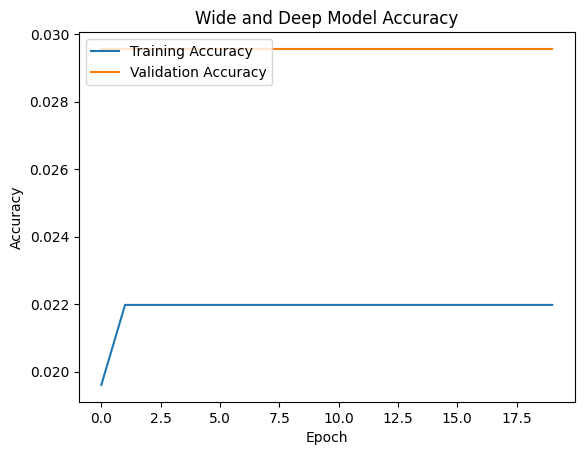

In [75]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Wide and Deep Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc = 'upper left')
plt.show()

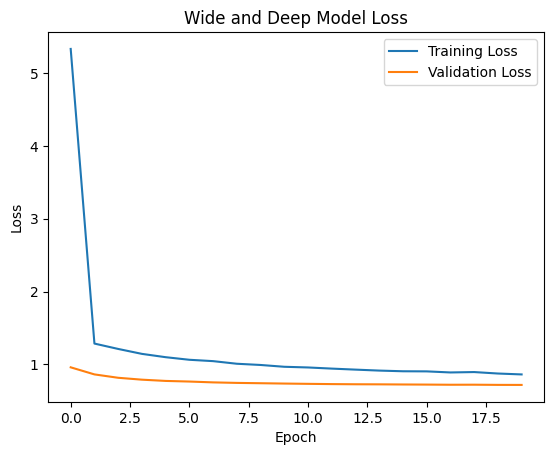

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wide and Deep Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc = 'upper right')
plt.show()

# Precision, Recall, F1 score, Visualization of Confusion Matrix on validation dataset

In [77]:
print(classification_report(y_true = val_ratings, y_pred = np.fmax(y_val_pred.flatten().round().astype(int), 1)))
print("\n\n")
print(confusion_matrix(y_true = val_ratings, y_pred = np.fmax(y_val_pred.flatten().round().astype(int), 1)))
print("\n\n")

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       195
         2.0       0.25      0.13      0.17       241
         3.0       0.31      0.29      0.30       841
         4.0       0.42      0.65      0.51      2164
         5.0       0.76      0.56      0.65      3155
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0

    accuracy                           0.53      6596
   macro avg       0.25      0.23      0.23      6596
weighted avg       0.55      0.53      0.52      6596




[[   0   41   59   83   12    0    0]
 [   0   31  103   99    8    0    0]
 [   0   27  248  487   79    0    0]
 [   0   13  277 1406  466    1    1]
 [   0   12  120 1242 1780    0    1]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

<Axes: >

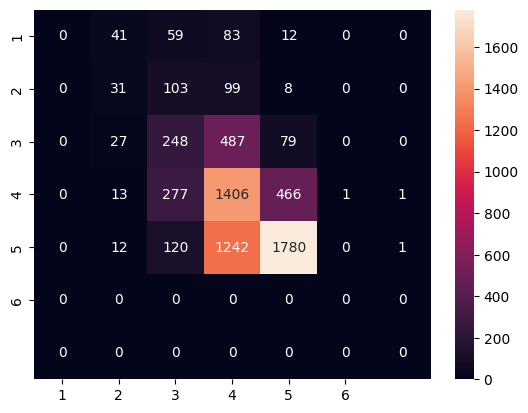

In [78]:
sns.heatmap(confusion_matrix(y_true = val_ratings,
                             y_pred = np.fmax(y_val_pred.flatten().round().astype(int), 1)),
                             annot = True,
                             fmt = ".0f",
                             xticklabels = ["1", "2", "3", "4", "5", "6"],
                             yticklabels = ["1", "2", "3", "4", "5", "6"])

# Prediction on Testing Dataset

Doing test prediction seems to have some problems

In [79]:
test_predict = wdl_model.predict(te_features)

207/207 [==============================] - 1s 2ms/step


In [80]:
test_predict

array([[4.057395 ],
       [4.564375 ],
       [3.8973794],
       ...,
       [3.666222 ],
       [4.375352 ],
       [4.3666267]], dtype=float32)

In [82]:
print(len(test_predict))

6597


In [81]:
pd.concat((te_df[["ReviewerID", "ProductID"]], pd.DataFrame(test_predict, columns=["Star"])), axis=1).to_csv("/content/drive/MyDrive/COMP4332 Project 3/prediction.csv", index=False)